In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Layer, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from matplotlib import pyplot as plt

2023-11-07 02:13:19.380567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 02:13:19.380599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 02:13:19.380626: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 02:13:19.387253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_dataset = np.concatenate([x_train, x_test])
mnist_dataset = np.expand_dims(mnist_dataset, -1).astype("float32")/255

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_dataset)

2023-11-07 02:13:23.124933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 02:13:23.129127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 02:13:23.129283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [5]:
train_dataset = (
    dataset
    .shuffle(buffer_size=BATCH_SIZE, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

### Encoder

In [7]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs

        return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))

In [8]:
encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name='encoder')

encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

### Decoder

In [9]:
latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder_model = Model(latent_inputs, decoder_output, name='decoder')

decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

# Overall VAE Model

In [10]:
vae_input = Input(shape=(28, 28, 1), name='vae_input')
z, _, _= encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [11]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 30

In [12]:
def custom_loss(y_true, y_pred, mean, log_var):

    loss_recons = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var + 1-tf.math.square(mean)-tf.math.exp(log_var)), axis=1))

    return loss_recons + loss_reg

In [13]:
class VAE(Model):
    def __init__(self, encoder_mode, decoder_model):
        super(VAE, self).__init__()
        self.encoder = encoder_mode
        self.decoder = decoder_model

        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, x_batch):
        with tf.GradientTape() as recorder:
            z, mean, log_var = encoder_model(x_batch)
            y_pred = decoder_model(z)
            y_true = x_batch
            loss = custom_loss(y_true, y_pred, mean, log_var)
            
        partial_derivatives = recorder.gradient(loss, self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {'loss':self.loss_tracker.result()}

In [14]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=20, batch_size=128, callbacks=[])

Epoch 1/20


2023-11-07 02:13:53.010867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-07 02:13:53.983634: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe64d1ec850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 02:13:53.983658: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-11-07 02:13:53.988264: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 02:13:54.073488: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 [==============================] - 10s 12ms/step - loss: 211.9589
Epoch 2/20
547/547 [==============================] - 6s 11ms/step - loss: 182.3306
Epoch 3/20
547/547 [==============================] - 6s 11ms/step - loss: 167.0944
Epoch 4/20
547/547 [==============================] - 6s 11ms/step - loss: 162.3396
Epoch 5/20
547/547 [==============================] - 6s 11ms/step - loss: 159.6208
Epoch 6/20
547/547 [==============================] - 6s 11ms/step - loss: 157.9938
Epoch 7/20
547/547 [==============================] - 6s 11ms/step - loss: 156.8200
Epoch 8/20
547/547 [==============================] - 6s 11ms/step - loss: 156.0246
Epoch 9/20
547/547 [==============================] - 6s 11ms/step - loss: 155.2357
Epoch 10/20
547/547 [==============================] - 6s 11ms/step - loss: 154.6132
Epoch 11/20
547/547 [==============================] - 6s 11ms/step - loss: 154.0161
Epoch 12/20
547/547 [==============================] - 6s 12ms/step - loss: 153.5775

In [57]:
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true, y_pred, mean, log_var)
        
    partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
    return loss

In [58]:
def neuralearn(epochs):
    for epoch in range(1, epochs+1):
        print("Training starts for epoch number {}".format(epoch))

        for step, x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
        print('Training loss is: ', loss.numpy())

    print("Training complete")

In [59]:
neuralearn(EPOCHS)

Training starts for epoch number 1
Training loss is:  202.4388
Training starts for epoch number 2
Training loss is:  202.36267
Training starts for epoch number 3
Training loss is:  203.0547
Training starts for epoch number 4


KeyboardInterrupt: 

# Testing

In [16]:
scale = 1
n = 16

In [17]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [18]:
print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 19ms/step


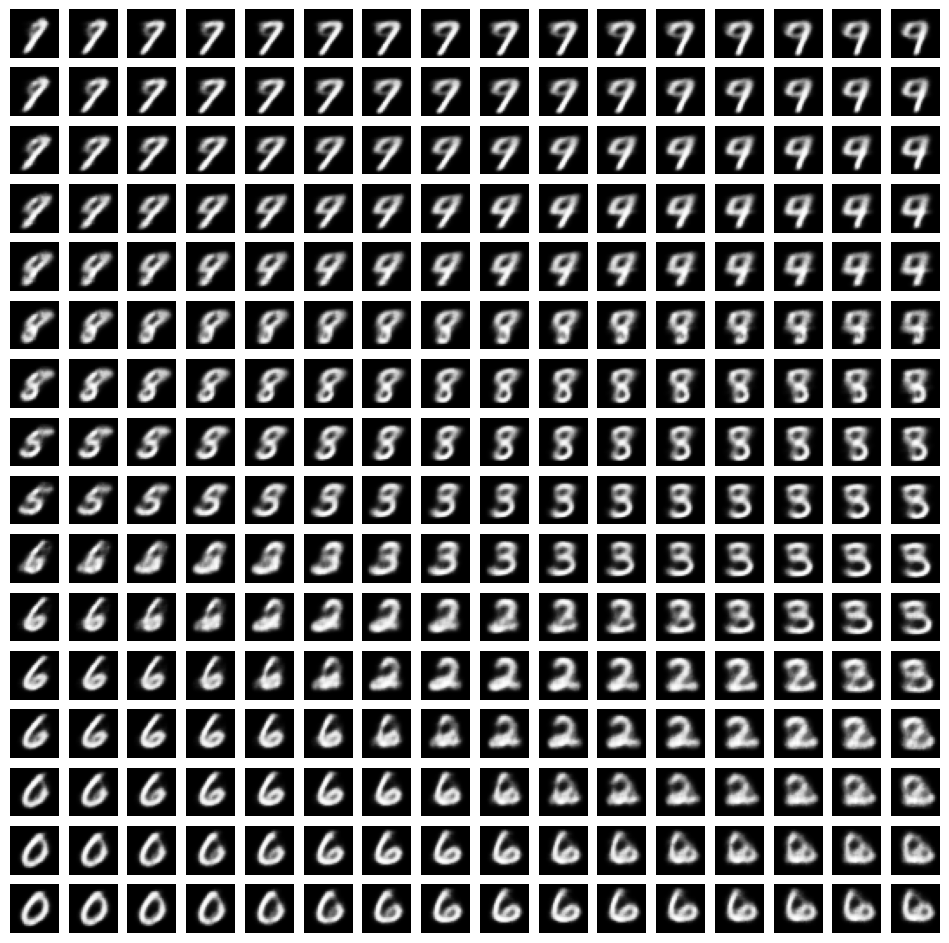

In [19]:
plt.figure(figsize=(12, 12))
k=0
for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n, n, k+1)

        input = tf.constant([[i, j]])
        out = model.decoder.predict(input)[0]#[..., 0]
        plt.imshow(out, cmap='Greys_r')
        plt.axis('off')
        k+=1


In [20]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_dataset = np.expand_dims(x_train, -1).astype('float32')/255

1875/1875 [==============================] - 3s 1ms/step


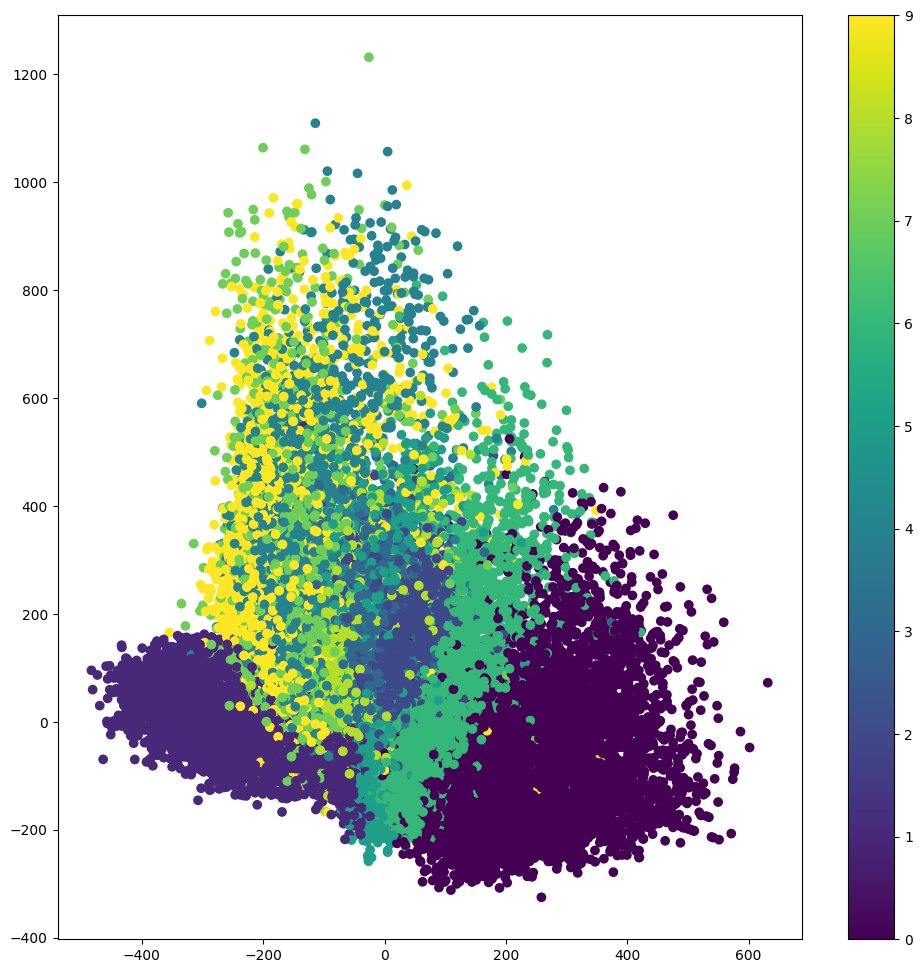

In [22]:
z,_,_ = model.encoder.predict(x_train)
plt.figure(figsize=(12, 12))
plt.scatter(z[:,0], z[:, 1], c=y_train)
plt.colorbar()
plt.show()

In [28]:
np.max(z[:, 1])

1.3941874e+31